In [2]:
import sys
!{sys.executable} -m pip install -r requirements.txt
import pydicom
import matplotlib.pylab as plt
import matplotlib
import os
import numpy as np
from PIL import Image
import time
import skimage.io as io
from unet.model import *
from unet.data import *


You should consider upgrading via the '/bin/python3 -m pip install --upgrade pip' command.


Configure Global Variables
----

In [3]:
window = 350 # Window/Level from Hoori et al ("HU-attention-window with a window/level of 350/40 HU")
level = 40
bitDepth = 8 # Must be 8 for uint8 PNGs. Explore floating point
TrainingDataRootDir = '../Training Data'
TestDataRootDir = '../Test Data'

Postprocess Test Data
----

Apply AI Fat Masks and Isolate Fat by HU
----

In [6]:
CombinedTestImageDir = TestDataRootDir + '/AllImages'
CombinedTestMaskDir = TestDataRootDir + '/AllMasks'
CombinedTestOutputMaskDir = TestDataRootDir + '/AllOutputMasks'
CombinedTestOutputImageDir = TestDataRootDir + '/AllOutputImages'
os.makedirs(CombinedTestOutputImageDir, exist_ok=True)

# fat
window = 80 
level = -110

currentImageIndex = 0
subjects = os.listdir(TestDataRootDir)
for subject in subjects:
    if not (subject == 'AllImages' or subject == 'AllMasks' or subject == 'AllOutputImages' or subject == 'AllOutputMasks'):
        currentSubjectDir = TestDataRootDir + "/" + subject;
        print(currentSubjectDir)

        volume_dicoms = os.listdir(currentSubjectDir + '/Dicom/Vol/')
        dataset_vol = [None] * (len(volume_dicoms))
        for dicom in volume_dicoms:
            slice_number = int(dicom.split('Slice')[1].split('.dcm')[0])
            dataset_vol[slice_number-1] = pydicom.dcmread(currentSubjectDir+'/Dicom/Vol/'+dicom)

        for i in range(1, len(dataset_vol)-1):
            sliceRGB = np.zeros((dataset_vol[i].pixel_array.shape[0],dataset_vol[i].pixel_array.shape[1],3))
            test_mask_result_path = os.path.join(CombinedTestOutputMaskDir,"%d.png"%currentImageIndex)
            resultMaskIn = io.imread(test_mask_result_path,as_gray = False)
            resultMaskScaled = resultMaskIn[:,:,1] / 255
            resultMaskResized = trans.resize(resultMaskScaled,(512,512))
            resultMask = resultMaskResized > 0.5
            maskedSlice = dataset_vol[i].pixel_array * resultMask
            maskedSlice = np.clip((maskedSlice - (level-window/2)) / window, 0,1) # Apply fat window/level and clip to 0->1 range
            for x in range(0,512):
                for y in range(0,512):
                    maskedSlice[x,y] = (maskedSlice[x,y]>0) and (maskedSlice[x,y]<1)
            maskedSlice = maskedSlice * ((2**bitDepth)-1) # Scale to bitdepth
            maskedSlice = np.floor(maskedSlice) # Floor to integer
            sliceRGB[:,:,0] = maskedSlice
            sliceRGB[:,:,1] = maskedSlice
            sliceRGB[:,:,2] = maskedSlice
            matplotlib.image.imsave(os.path.join(CombinedTestOutputImageDir,"%d.png"%currentImageIndex), sliceRGB.astype(np.uint8))
            currentImageIndex = currentImageIndex + 1

../Test Data/SA209


KeyboardInterrupt: 

Apply Original Fat Masks and Isolate Fat by HU
----

In [7]:
CombinedTestImageDir = TestDataRootDir + '/AllImages'
CombinedTestMaskDir = TestDataRootDir + '/AllMasks'
CombinedTestOutputMaskDir = TestDataRootDir + '/AllOutputMasks'
CombinedTestOutputImageDir = TestDataRootDir + '/AllOutputImages'
CombinedTestReferenceImageDir = TestDataRootDir + '/AllReferenceImages'
CombinedTestOutputCombinedImageDir = TestDataRootDir + '/AllCombinedResultImages'
os.makedirs(CombinedTestOutputImageDir, exist_ok=True)
os.makedirs(CombinedTestReferenceImageDir, exist_ok=True)
os.makedirs(CombinedTestOutputCombinedImageDir, exist_ok=True)


window = 350 # Window/Level from Hoori et al ("HU-attention-window with a window/level of 350/40 HU")
level = 40
# fat
fatWindow = 80 
fatLevel = -110

currentImageIndex = 0
subjects = os.listdir(TestDataRootDir)
subjectVoxelCountsReference = []
subjectVoxelCountsResults = []

for subject in subjects:
    if not (subject == 'AllImages' or subject == 'AllMasks' or subject == 'AllOutputImages' or subject == 'AllOutputMasks' or subject == 'AllReferenceImages' or subject == 'AllCombinedResultImages'):
        currentSubjectDir = TestDataRootDir + "/" + subject
        print(currentSubjectDir)
        subjectVoxelCountReference = 0
        subjectVoxelCountResults = 0

        volume_dicoms = os.listdir(currentSubjectDir + '/Dicom/Vol/')
        dataset_vol = [None] * (len(volume_dicoms))
        for dicom in volume_dicoms:
            slice_number = int(dicom.split('Slice')[1].split('.dcm')[0])
            dataset_vol[slice_number-1] = pydicom.dcmread(currentSubjectDir+'/Dicom/Vol/'+dicom)

        for i in range(1, len(dataset_vol)-1):
            sliceRGB = np.zeros((dataset_vol[i].pixel_array.shape[0],dataset_vol[i].pixel_array.shape[1],3))
            originalInput = dataset_vol[i].pixel_array
            windowLeveledOriginalInput = np.clip((originalInput - (level-window/2)) / window, 0,1) # Apply fat window/level and clip to 0->1 range
            windowLeveledOriginalInput = windowLeveledOriginalInput * ((2**bitDepth)-1) # Scale to bitdepth
            windowLeveledOriginalInput = np.floor(windowLeveledOriginalInput) # Floor to integer

            test_mask_input_path = os.path.join(CombinedTestMaskDir,"%d.png"%currentImageIndex)
            MaskIn_input = io.imread(test_mask_input_path,as_gray = False)
            MaskScaled_input = MaskIn_input[:,:,1] / 255
            MaskResized_input = trans.resize(MaskScaled_input,(512,512))
            Mask_input = MaskResized_input > 0.5
            maskedSlice_input = originalInput * Mask_input
            maskedSlice_input = np.clip((maskedSlice_input - (fatLevel-fatWindow/2)) / fatWindow, 0,1) # Apply fat window/level and clip to 0->1 range


            test_mask_result_path = os.path.join(CombinedTestOutputMaskDir,"%d.png"%currentImageIndex)
            MaskIn_result = io.imread(test_mask_result_path,as_gray = False)
            MaskScaled_result = MaskIn_result[:,:,1] / 255
            MaskResized_result = trans.resize(MaskScaled_result,(512,512))
            Mask_result = MaskResized_result > 0.5
            maskedSlice_result = originalInput * Mask_result
            maskedSlice_result = np.clip((maskedSlice_result - (fatLevel-fatWindow/2)) / fatWindow, 0,1) # Apply fat window/level and clip to 0->1 range

            for x in range(0,512):
                for y in range(0,512):
                    maskedSlice_input[x,y] = (maskedSlice_input[x,y]>0) and (maskedSlice_input[x,y]<1)
                    maskedSlice_result[x,y] = (maskedSlice_result[x,y]>0) and (maskedSlice_result[x,y]<1)

            subjectVoxelCountReference = subjectVoxelCountReference + np.count_nonzero(maskedSlice_input)
            maskedSlice_input_scaled = maskedSlice_input * ((2**bitDepth)-1) # Scale to bitdepth
            maskedSlice_input_scaled = np.floor(maskedSlice_input_scaled) # Floor to integer

            subjectVoxelCountResults = subjectVoxelCountResults + np.count_nonzero(maskedSlice_result)
            maskedSlice_result_scaled = maskedSlice_result * ((2**bitDepth)-1) # Scale to bitdepth
            maskedSlice_result_scaled = np.floor(maskedSlice_result_scaled) # Floor to integer

            # Save original fat mask
            sliceRGB[:,:,0] = (windowLeveledOriginalInput * 0.5) + (0.5 * maskedSlice_input_scaled)
            sliceRGB[:,:,1] = (windowLeveledOriginalInput * 0.5) 
            sliceRGB[:,:,2] = (windowLeveledOriginalInput * 0.5) 
            matplotlib.image.imsave(os.path.join(CombinedTestReferenceImageDir,"%d.png"%currentImageIndex), sliceRGB.astype(np.uint8))

            # Save AI fat mask
            sliceRGB[:,:,0] = (windowLeveledOriginalInput * 0.5) 
            sliceRGB[:,:,1] = (windowLeveledOriginalInput * 0.5) 
            sliceRGB[:,:,2] = (windowLeveledOriginalInput * 0.5) + (0.5 * maskedSlice_result_scaled)
            matplotlib.image.imsave(os.path.join(CombinedTestOutputImageDir,"%d.png"%currentImageIndex), sliceRGB.astype(np.uint8))

            # Save Combined fat mask
            sliceRGB[:,:,0] = (windowLeveledOriginalInput * 0.5) + (0.5 * maskedSlice_input_scaled)
            sliceRGB[:,:,1] = (windowLeveledOriginalInput * 0.5) 
            sliceRGB[:,:,2] = (windowLeveledOriginalInput * 0.5) + (0.5 * maskedSlice_result_scaled)
            matplotlib.image.imsave(os.path.join(CombinedTestOutputCombinedImageDir,"%d.png"%currentImageIndex), sliceRGB.astype(np.uint8))

            currentImageIndex = currentImageIndex + 1
        subjectVoxelCountsReference.append(subjectVoxelCountReference)
        subjectVoxelCountsResults.append(subjectVoxelCountResults)


../Test Data/SA201
../Test Data/CA024
../Test Data/CA039
../Test Data/CA036
../Test Data/CA061
../Test Data/CA020


FileNotFoundError: No such file: '/workspaces/461-EAT-Project/Test Data/AllOutputMasks/320.png'

In [10]:
totalEATVolumeReference = []
totalEATVolumeResult = []
EATVolumeError = []
EATPercentError = []
for subjectNumber in range(0,len(subjectVoxelCountsResults)):
    totalEATVolumeReference.append(subjectVoxelCountsReference[subjectNumber]*2.5*0.8671875*0.8671875)
    totalEATVolumeResult.append(subjectVoxelCountsResults[subjectNumber]*2.5*0.8671875*0.8671875)
    EATVolumeError.append(np.abs(totalEATVolumeReference[subjectNumber] - totalEATVolumeResult[subjectNumber]))
    EATPercentError.append(EATVolumeError[subjectNumber] / totalEATVolumeResult[subjectNumber])

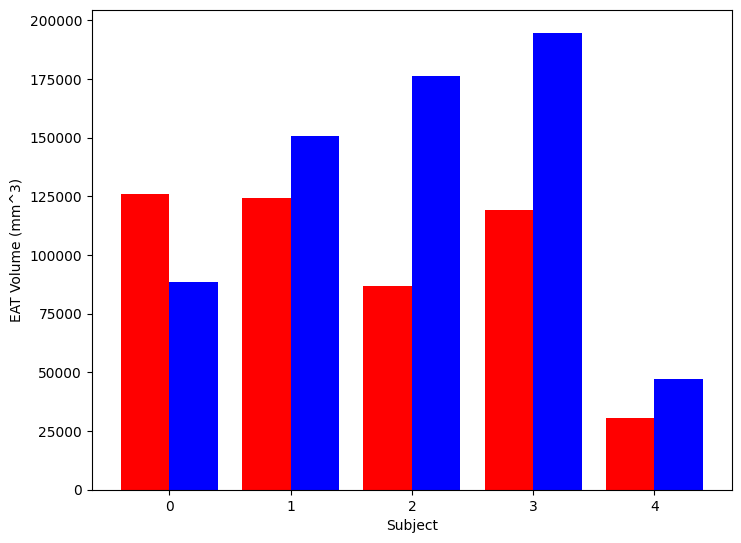

[37775.55130004883, 26406.97723388672, 89348.68240356445, 75729.70596313477, 16839.477081298828]
[0.4273560627007253, 0.17547848683224226, 0.5074854775328891, 0.38886904474586087, 0.35632732625213825]


In [11]:
subjectNumbers = range(0,len(subjectVoxelCountsResults))

X = np.arange(len(subjectVoxelCountsResults))
fig=plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X - 0.2, totalEATVolumeReference, color = 'r', width = 0.4)
ax.bar(X + 0.2, totalEATVolumeResult, color = 'b', width = 0.4)
ax.set_xlabel("Subject")
ax.set_ylabel("EAT Volume (mm^3)")
plt.show()

print(EATVolumeError)
print(EATPercentError)

In [12]:
print(np.mean(EATPercentError))
print(np.std(EATPercentError))

0.3711032796127712
0.11006133769273133


## Total Volume References:
[111377.0571899414, 110123.07357788086, 141055.2960205078, 49334.00894165039, 201865.04104614258, 146345.71563720703, 150350.19104003906, 89871.33224487305, 433859.5294189453, 168212.4073791504, 175849.1111755371, 70238.12255859375, 85733.37432861328, 26002.769622802734, 197375.51651000977, 126169.17572021484, 124078.57635498047, 94560.14053344727, 70288.8835144043, 138603.72985839844, 104048.67919921875, 74361.04019165039, 109348.49899291992, 77607.861328125, 188766.8344116211, 354473.1546020508, 86712.8727722168, 31246.188354492188, 69080.02075195312, 118532.47192382812, 119013.76098632812, 52513.14880371094, 30418.972778320312, 43881.90628051758, 32849.85855102539, 225440.68496704102, 98164.1683959961, 65402.67150878906, 154948.75762939453, 57878.76983642578]

## Total Volume Results:
[96977.86605834961, 81445.01358032227, 185926.10092163086, 85090.40222167969, 181489.21737670898, 255823.9370727539, 162111.6925048828, 330476.38275146484, 454485.39779663086, 223226.00326538086, 105069.53842163086, 72405.80337524414, 310444.60556030273, 56585.30548095703, 131232.1110534668, 121204.0022277832, 174632.72827148438, 128051.09115600586, 183258.33068847656, 193852.33016967773, 74297.11898803711, 285825.5419921875, 80668.55895996094, 108562.64419555664, 403231.87271118164, 199492.4363708496, 262603.3447265625, 58326.21826171875, 64041.52587890625, 232440.0567626953, 165612.31842041016, 208969.69482421875, 165824.7624206543, 62996.22619628906, 63473.75518798828, 150274.98962402344, 197445.07781982422, 107855.75088500977, 144668.7240600586, 135236.58645629883]

## Volume Errors:
[14399.191131591797, 28678.059997558594, 44870.80490112305, 35756.3932800293, 20375.823669433594, 109478.22143554688, 11761.50146484375, 240605.0505065918, 20625.868377685547, 55013.59588623047, 70779.57275390625, 2167.6808166503906, 224711.23123168945, 30582.535858154297, 66143.40545654297, 4965.173492431641, 50554.151916503906, 33490.950622558594, 112969.44717407227, 55248.6003112793, 29751.56021118164, 211464.5018005371, 28679.940032958984, 30954.78286743164, 214465.03829956055, 154980.71823120117, 175890.4719543457, 27080.029907226562, 5038.494873046875, 113907.58483886719, 46598.55743408203, 156456.5460205078, 135405.78964233398, 19114.319915771484, 30623.89663696289, 75165.69534301758, 99280.90942382812, 42453.0793762207, 10280.033569335938, 77357.81661987305]

## Percent Errors:
[0.12928327875493736, 0.26041826717883054, 0.3181079063816175, 0.7247818299607485, 0.1009378521602265, 0.7480794429742299, 0.078227379582854, 2.677216911072527, 0.04754042951484582, 0.3270483833111665, 0.40250173731758165, 0.03086188436830835, 2.6210473224858557, 1.1761260935579496, 0.3351145401724056, 0.03935330055133363, 0.4074365889875451, 0.3541761934111378, 1.6072164121218606, 0.39860832293418696, 0.285938855160451, 2.8437539503956715, 0.26228014373398895, 0.39886143410852715, 1.136137282632512, 0.43721426071091407, 2.028423996704464, 0.8666666666666667, 0.07293707816242108, 0.9609821088694328, 0.3915392392265892, 2.9793784906200775, 4.451359703337453, 0.43558545049483743, 0.9322383105362559, 0.3334167271271672, 1.0113762592408166, 0.649103139013453, 0.06634473052003204, 1.3365490807509908]